In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, roc_auc_score, confusion_matrix, classification_report)

# Load Dataset
df = pd.read_csv('../data/raw/ecommerce_churn_dummy.csv')

In [37]:
# Menghapus kolom ID karena tidak memiliki nilai prediktif
df_model = df.drop(['ID_Pelanggan'], axis=1)

# Menangani missing values jika ada
df_model = df_model.fillna(df_model.median(numeric_only=True))

# Transformasi Kategorikal ke Numerik (One-Hot Encoding)
df_model = pd.get_dummies(df_model, drop_first=True)

# Memisahkan Fitur (X) dan Target (y)
X = df_model.drop('Churn', axis=1)
y = df_model['Churn']

# Split Data (80% Training, 20% Testing) dengan Stratify agar proporsi target seimbang
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dimensi Data Training: {X_train.shape}")
print(f"Dimensi Data Testing: {X_test.shape}")

Dimensi Data Training: (1600, 17)
Dimensi Data Testing: (400, 17)


In [38]:
# --- MODEL 1: RANDOM FOREST (Baseline) ---
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# --- MODEL 2: XGBOOST DENGAN HYPERPARAMETER TUNING ---
print("Memulai Hyperparameter Tuning untuk XGBoost...")
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1]
}

xgb_base = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
grid_search = GridSearchCV(estimator=xgb_base, param_grid=param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_xgb = grid_search.best_estimator_
print(f"Parameter Terbaik XGBoost: {grid_search.best_params_}")

Memulai Hyperparameter Tuning untuk XGBoost...
Parameter Terbaik XGBoost: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 100}


c:\Users\GF63\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\training.py:199: UserWarning: [16:05:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [39]:
def get_metrics(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    return {
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_prob)
    }

# Membandingkan Hasil
results = pd.DataFrame([
    get_metrics(rf, X_test, y_test, "Random Forest"),
    get_metrics(best_xgb, X_test, y_test, "XGBoost (Tuned)")
])

print("\n--- Tabel Perbandingan Performa ---")
display(results)


--- Tabel Perbandingan Performa ---


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.6675,0.166667,0.016,0.029197,0.462356
1,XGBoost (Tuned),0.6250,0.272727,0.120,0.166667,0.471069



Menghitung SHAP Values...


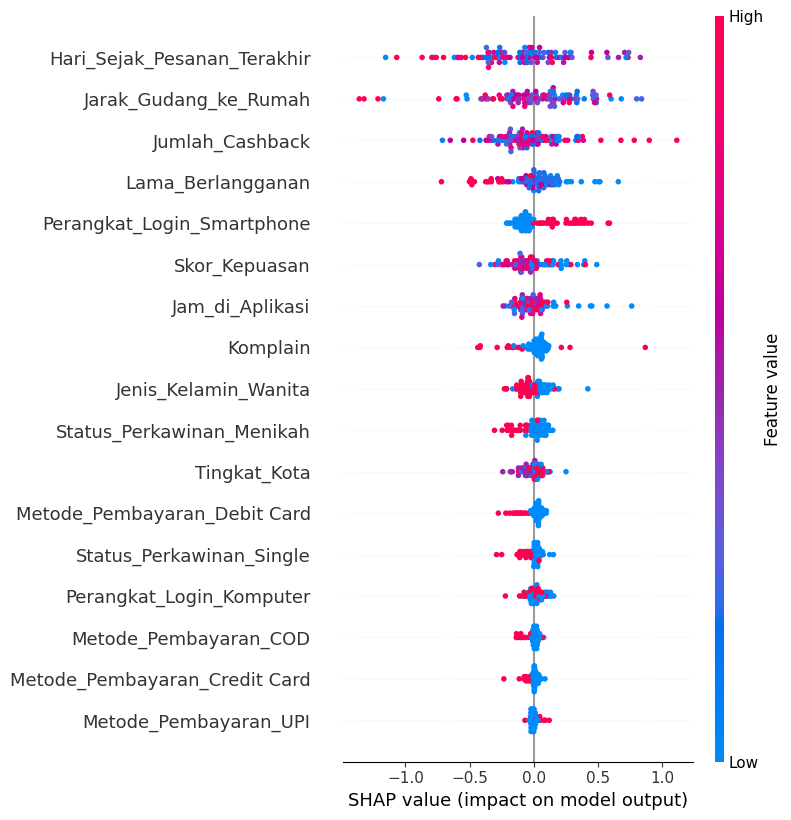

In [40]:
print("\nMenghitung SHAP Values...")
explainer = shap.TreeExplainer(best_xgb)
# Menggunakan 100 sampel agar proses tidak pending/lama
shap_values = explainer.shap_values(X_test.iloc[:100])

# Summary Plot
shap.summary_plot(shap_values, X_test.iloc[:100])

In [41]:
# Simpan Model dan Metadata Kolom
joblib.dump(best_xgb, '../models/best_model.pkl')
joblib.dump(X_train.columns.tolist(), '../models/column_names.pkl')

print("\nSukses! File 'best_model.pkl' dan 'column_names.pkl' tersimpan di folder models/.")


Sukses! File 'best_model.pkl' dan 'column_names.pkl' tersimpan di folder models/.
